# Importando dados

importando as bibliotecas que usaremos no ao longo do projeto.

In [745]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [746]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [747]:
# Bibliotecas padrão para manipulação dos dados
import pandas as pd
import numpy as np
import datetime as dt

# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import warnings
warnings.filterwarnings('ignore')

In [748]:
# Importando o dataframe
df_original = pd.read_csv('C:/Users/Winicius/Desktop/LightHouse/teste_indicium_precificacao.csv', sep = ',')

In [749]:
# Criando uma cópia para casos de fazer alterações, ainda teremos o principal
df = df_original.copy()

# Análise Explratória dos dados (EDA)

In [750]:
# Visualizando as 5 primeiras colunas para nos familiarizarmos com os dados
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [751]:
# Verificando o tamanho do Dataframe
df.shape

(48894, 16)

In [752]:
# Verificando os tipos das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [753]:
# Verificando a quantidade de valores faltantes
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [754]:
# Verificando a porcentagem dos valores faltantes
(df.isnull().sum()/df.shape[0]*100).round(3)

id                                0.000
nome                              0.033
host_id                           0.000
host_name                         0.043
bairro_group                      0.000
bairro                            0.000
latitude                          0.000
longitude                         0.000
room_type                         0.000
price                             0.000
minimo_noites                     0.000
numero_de_reviews                 0.000
ultima_review                    20.559
reviews_por_mes                  20.559
calculado_host_listings_count     0.000
disponibilidade_365               0.000
dtype: float64

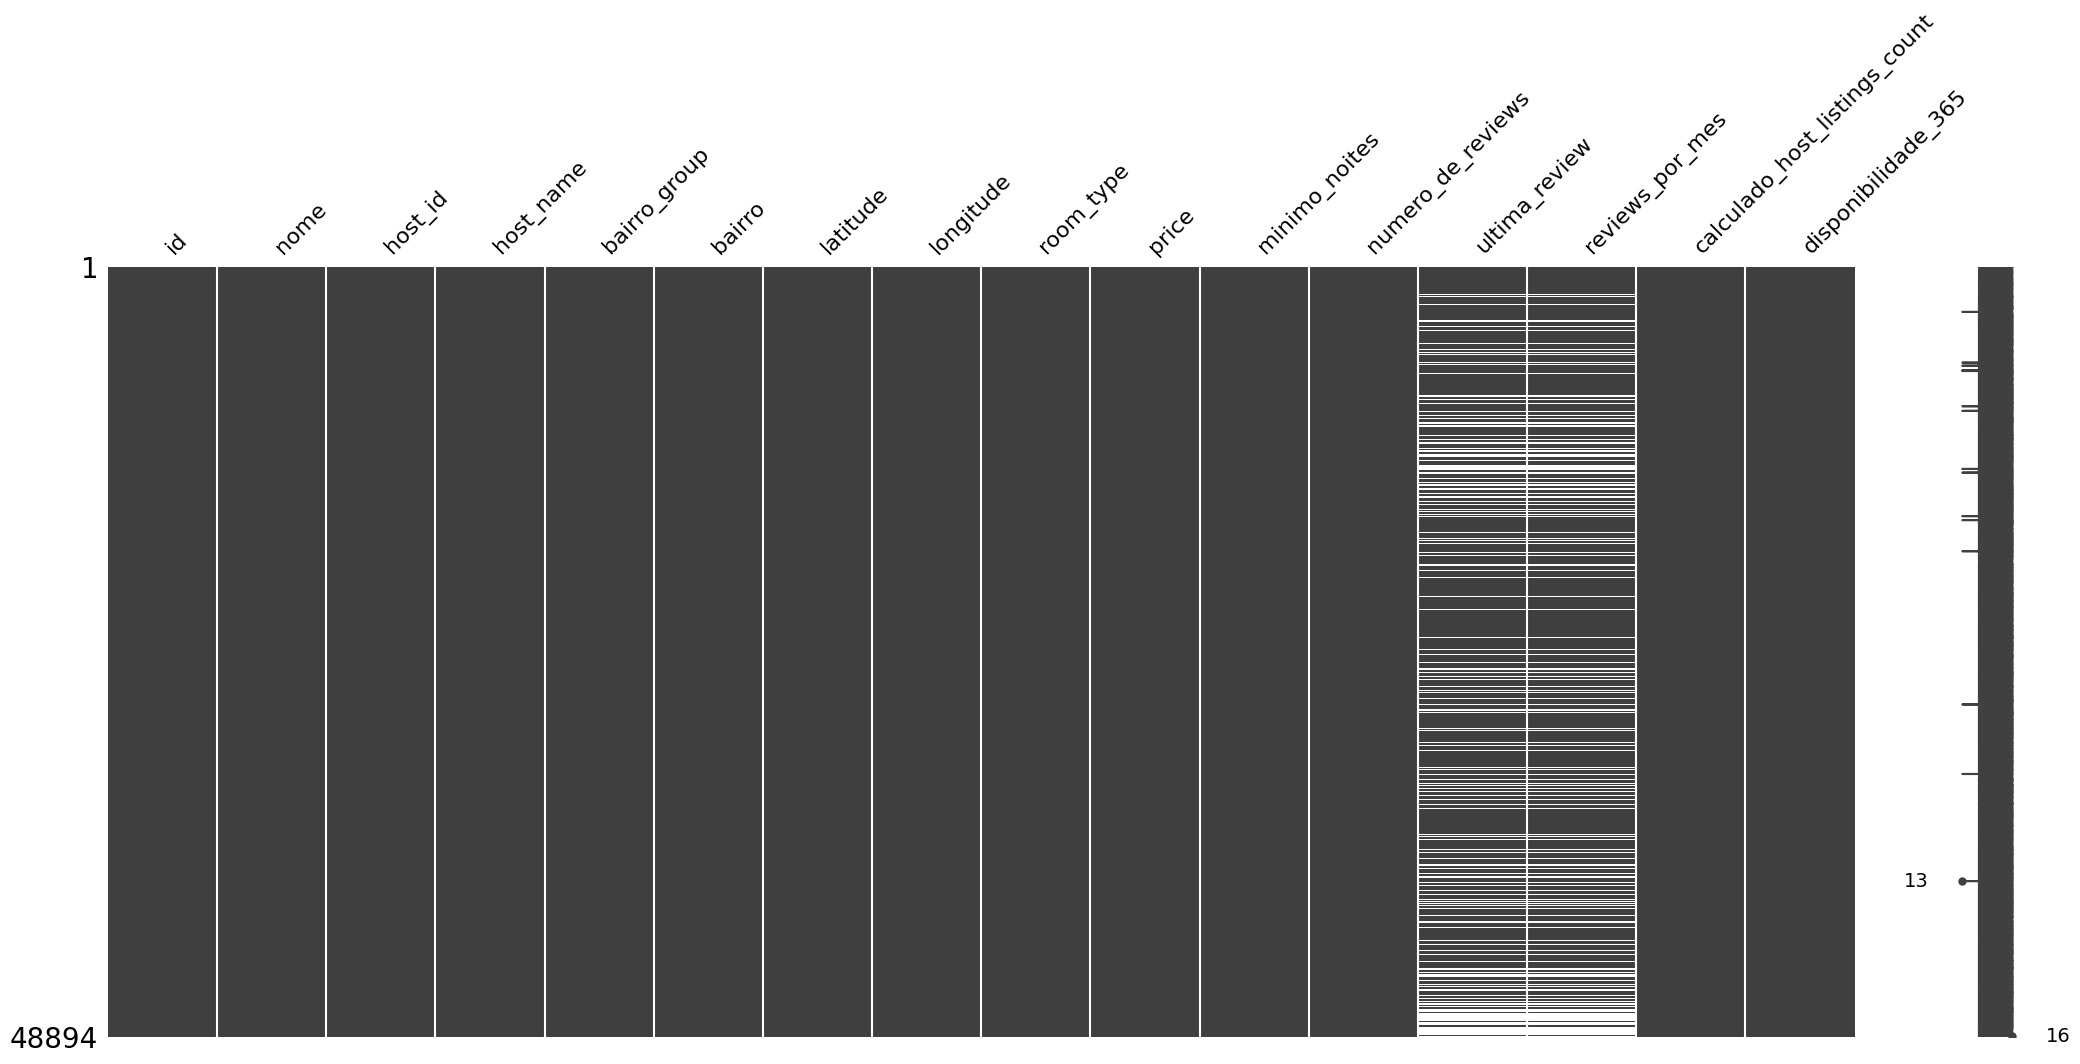

In [755]:
missingno.matrix(df);

Podemos observar que as variáveis última_review e reviews_por_mês são as que têm mais valores ausentes, com aproximadamente 20% em cada uma.

## Analisando os diferentes bairros

In [756]:
# Verificando quantas ocorrências existem em cada variável
df.nome.value_counts().head()

nome
Hillside Hotel                      18
Home away from home                 17
New york Multi-unit building        16
Brooklyn Apartment                  12
Loft Suite @ The Box House Hotel    11
Name: count, dtype: int64

In [757]:
df.bairro.value_counts().head()

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Name: count, dtype: int64

In [758]:
df.bairro_group.value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Podemos notar que a análise dos grupos de bairros faz mais sentido, pois eles apresentam uma quantidade menor de variáveis a serem analisadas.

In [759]:
df.groupby("bairro_group")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
bairro_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20103.0,124.381983,186.878105,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


Algumas conclusões:

* O bairro mais caro em média é Manhattan, com um preço médio de 196.88 dólares. O bairro mais barato em média é Bronx, com um preço médio de 87.50 dólares.
* O bairro com maior variação de preços também é Manhattan, com um desvio padrão de 291.38 dólares. Isso significa que os preços dos imóveis nesse bairro são mais dispersos em torno da média. O bairro com menor variação de preços é Bronx, com um desvio padrão de 106.71 dólares. Isso significa que os preços dos imóveis nesse bairro são mais concentrados em torno da média.
* O bairro com maior valor máximo é Manhattan, com um preço máximo de 10.000 dólares. O bairro com menor valor mínimo é Bronx, com um preço mínimo de 0 dólar. Isso pode indicar que há imóveis gratuitos ou muito baratos nesse bairro, ou que há algum erro nos dados (o mais provável).
* O bairro com maior número de locações é Brooklyn, com 20.103. O bairro com menor número de locações é Staten Island, com apenas 373.
* O bairro com maior proporção de locações em relação ao total é Manhattan, com 38.6% das locações. O bairro com menor proporção em relação ao total é Staten Island, com apenas 0.7%.

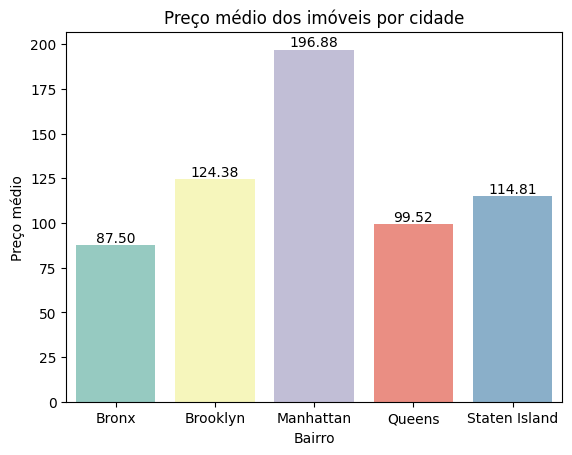

In [760]:
# Agrupar o dataframe por cidade e calcular a média do preço
df_grouped = df.groupby('bairro_group')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Bairro')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por cidade')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço médio dos imóveis varia consideravelmente entre os diferentes bairros. Manhattan tem o preço médio mais alto, seguido por Brooklyn, Staten Island, Queens e Bronx.
* O preço médio de Manhattan é mais do que o dobro do preço médio de Bronx, o bairro mais barato. Isso indica uma grande disparidade econômica e social entre os bairros.
* O preço médio de Staten Island é maior do que o de Queens, apesar de ser um bairro mais afastado e menos populoso. Isso pode sugerir uma maior qualidade de vida ou uma menor oferta de imóveis no bairro.
* O preço médio de Brooklyn é próximo do de Staten Island, mas com uma maior variação. Isso pode refletir a diversidade cultural e arquitetônica do bairro, que possui áreas mais nobres e outras mais simples.

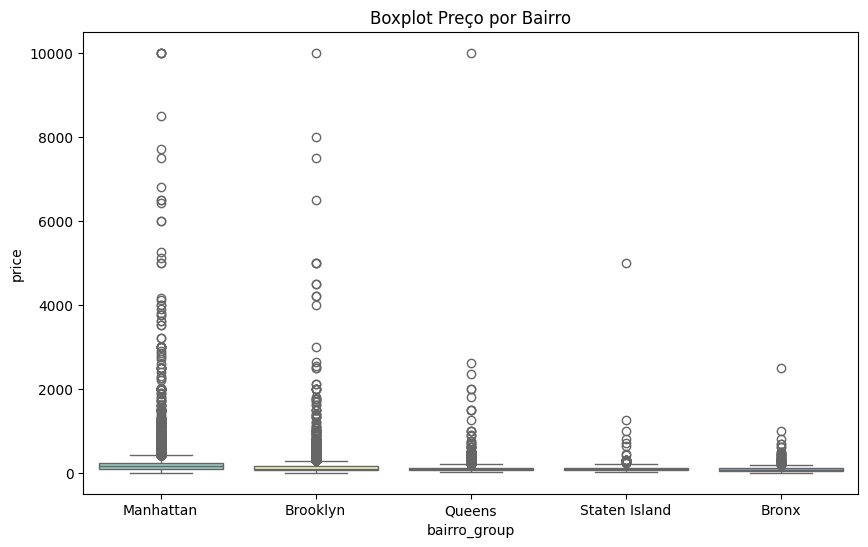

In [761]:
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y='price', data=df, order=bairros, palette=sns.color_palette("Set3", 5))

# Definir o título do gráfico como 'Boxplot Preço por Bairro'
ax.set_title('Boxplot Preço por Bairro')

# Mostrar o gráfico
plt.show()

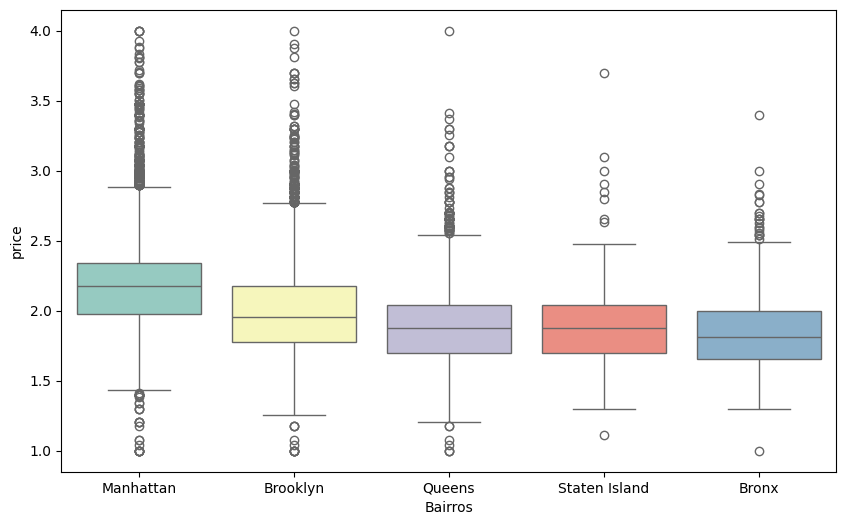

In [762]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize = (10,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, order = bairros, palette = sns.color_palette("Set3", 5))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

A partir desses boxplots, podemos concluir que:
* Manhattan tem uma variação de preço significativamente maior e preços mais altos em comparação com os outros bairros. 
* Brooklyn e Queens têm uma variação de preço semelhante, mas Brooklyn tem preços ligeiramente mais altos. 
* Staten Island e Bronx têm a menor variação de preço e os preços mais baixos.

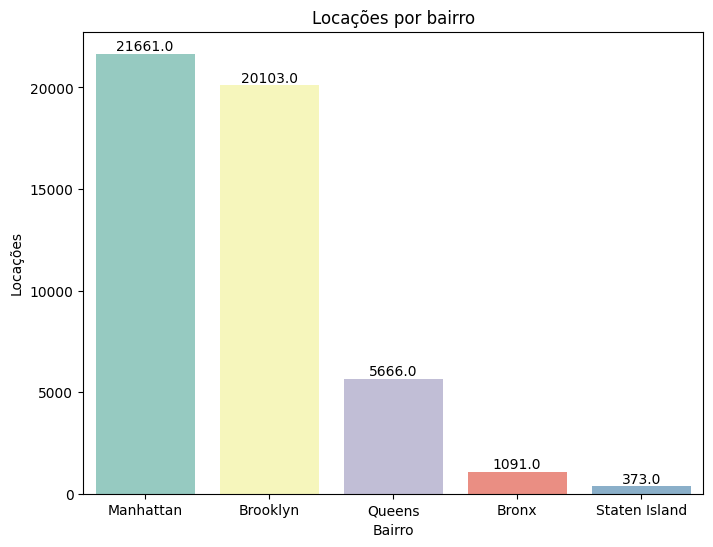

In [763]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='bairro_group', data=df, order= df['bairro_group'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Bairro'
ax.set_xlabel('Bairro')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Locações por bairro')

# Mostrar o gráfico
plt.show()

Como vimos na tabela anterior, a quantidade de locações nos bairros de Manhattan e Brooklyn estão muito acima dos demais bairros.

Conclusões finais:
* Manhattan é o bairro mais desejado e disputado de imóveis em Nova York, mas também o mais caro e instável. Os imóveis nesse bairro podem ter preços exorbitantes ou muito baixos, dependendo da oferta e da procura. Além disso, há uma grande desigualdade social e econômica entre as diferentes áreas de Manhattan.
* Brooklyn e Queens são os bairros mais equilibrados e diversificados em termos de preços e tipos de imóveis em Nova York. Eles oferecem opções mais acessíveis e variadas do que Manhattan, mas também têm áreas mais valorizadas e outras menos. Eles também têm uma maior oferta e demanda de imóveis do que os outros bairros.
* Staten Island e Bronx são os bairros mais baratos e isolados em termos de preços e tipos de imóveis em Nova York. Eles têm pouca oferta e demanda de imóveis, e os preços são mais estáveis e baixos do que nos outros bairros. Eles podem ser uma boa opção para quem busca tranquilidade e economia, mas também podem ter menos infraestrutura e serviços.

## Room Type

In [764]:
df.room_type.value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

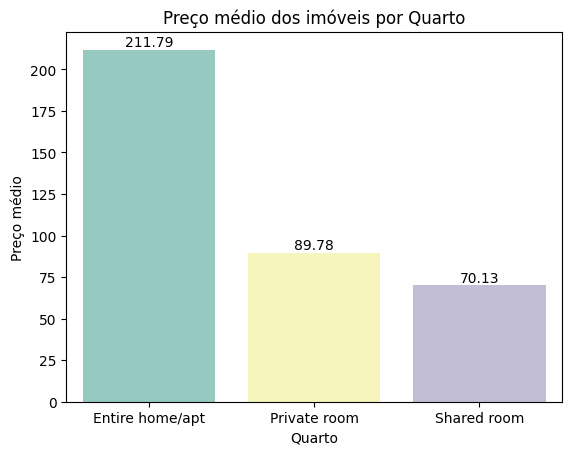

In [765]:
# Agrupar o dataframe por Quarto e calcular a média do preço
df_grouped = df.groupby('room_type')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Quarto')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Quarto')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço médio dos imóveis varia significativamente dependendo do tipo de quarto. O preço médio é mais alto para um apartamento/casa inteira, seguido por um quarto privado e, finalmente, um quarto compartilhado.
* A diferença de preço entre um apartamento/casa inteira e um quarto privado é de cerca de 122 dolares, o que representa uma variação de aproximadamente 136%. Isso indica que há uma grande demanda por espaços maiores e mais privados na área.
* A diferença de preço entre um quarto privado e um quarto compartilhado é de cerca de 20 dolares, o que representa uma variação de cerca de 22%. Isso sugere que há uma oferta limitada de quartos compartilhados na área, ou que as pessoas preferem pagar um pouco mais por um quarto privado.

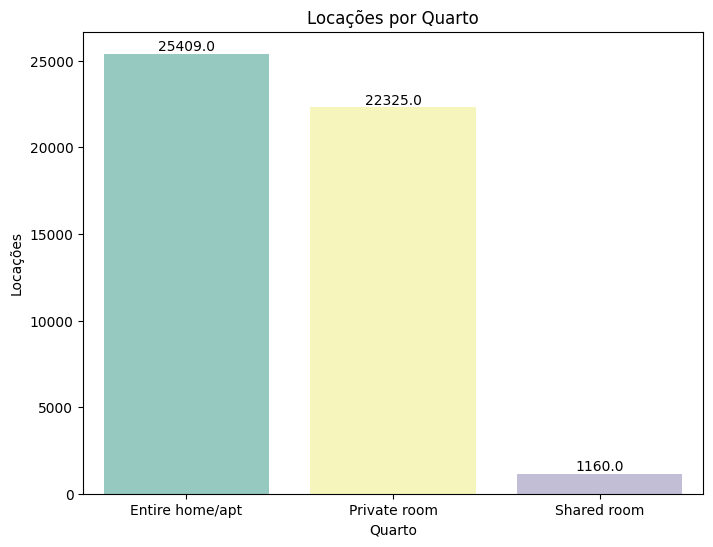

In [766]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='room_type', data=df, order= df['room_type'].value_counts().index, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Tipo de quarto'
ax.set_xlabel('Quarto')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Locações por Quarto')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* As locações de casas/apartamentos inteiros são mais populares, seguidas por quartos privados e, por último, quartos compartilhados.
* A demanda por quartos compartilhados é muito baixa, representando apenas cerca de 4% do total de locações.
* A diferença entre as locações de casas/apartamentos inteiros e quartos privados é pequena, indicando que ambos os tipos de quarto têm uma demanda semelhante.
* O gráfico pode sugerir que as pessoas preferem ter mais privacidade e conforto ao alugar um espaço, ou que há uma escassez de opções de quartos compartilhados na área.

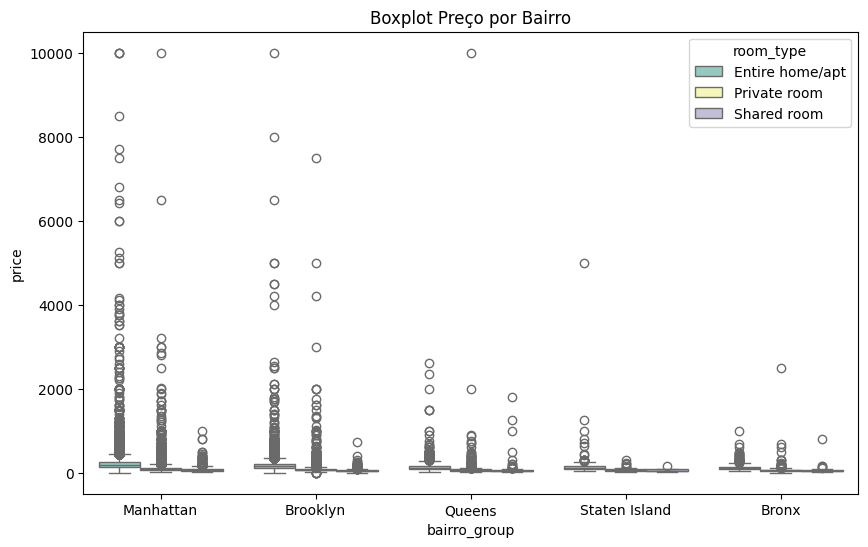

In [767]:
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y='price', data=df, hue = 'room_type',
                 order=bairros, palette=sns.color_palette("Set3", 5))

# Definir o título do gráfico como 'Boxplot Preço por Bairro'
ax.set_title('Boxplot Preço por Bairro')

# Mostrar o gráfico
plt.show()

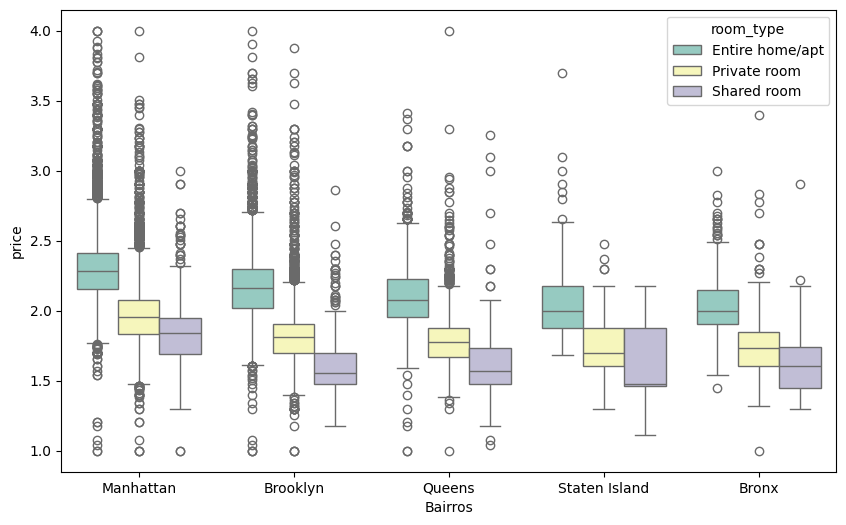

In [768]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize = (10,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, 
                 hue = 'room_type',order = bairros, 
                 palette = sns.color_palette("Set3", 5))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço dos quartos varia consideravelmente dentro de cada bairro e tipo de quarto. Manhattan tem os preços mais altos, especialmente para casas/apartamentos inteiros. Os quartos compartilhados geralmente são mais baratos em todos os bairros.
* Brooklyn e Queens têm uma distribuição semelhante dos preços dos quartos, mas Brooklyn tem mais outliers nos preços mais altos.
* Staten Island e Bronx têm menos dados representados no gráfico, indicando menores listagens disponíveis ou dados coletados.

Conclusões finais:

* Alugar um apartamento/casa inteira em Nova York é uma opção cara e competitiva, que requer uma renda alta e uma boa verificação de crédito. Muitas pessoas optam por essa opção por questões de privacidade, conforto e status.
* Alugar um quarto privado em Nova York é uma opção mais acessível e flexível, que permite economizar dinheiro e conviver com outras pessoas. Muitas pessoas escolhem essa opção por questões de praticidade, conveniência e sociabilidade.
* Alugar um quarto compartilhado em Nova York é uma opção rara e barata, que exige uma adaptação maior e uma tolerância maior. Poucas pessoas preferem essa opção por questões de necessidade, oportunidade ou experiência.
* Os bairros de Nova York têm características diferentes que influenciam nos preços e na disponibilidade dos quartos. Manhattan é o bairro mais caro e disputado, Brooklyn e Queens são os bairros mais diversificados e equilibrados, e Staten Island e Bronx são os bairros mais baratos e isolados.

## Minimo Noites

In [769]:
# Top 10 noites minimos
df.minimo_noites.value_counts().head(10)

minimo_noites
1     12719
2     11696
3      7999
30     3760
4      3303
5      3034
7      2058
6       752
14      562
10      483
Name: count, dtype: int64

In [770]:
# Procentagem top 10 em relação ao total
round((sum(df.minimo_noites.value_counts().head(10))/sum(df.minimo_noites.value_counts()))*100, 2)

94.83

Analisaremos apenas as 10 quantidades minimas de noites, com maior número de aluguéis, para facilitar a visualização, pois o top 10 representa 94,83% dos dados.

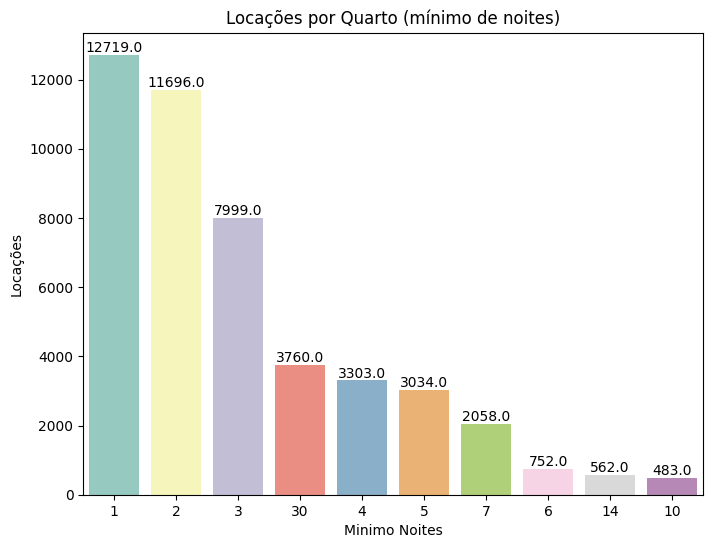

In [771]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='minimo_noites', data=df[df['minimo_noites'].isin(top_minimo_noites)], order=top_minimo_noites, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
        plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                ax.patches[i].get_width() / 2, 
                                                ax.patches[i].get_height()), 
                                                size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Minimo Noites'
ax.set_xlabel('Minimo Noites')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por Quarto'
ax.set_title('Locações por Quarto (mínimo de noites)')

# Mostrar o gráfico
plt.show()


Algumas conclusões:

* A maioria dos quartos tem um mínimo de 1 ou 2 noites, o que indica uma alta demanda por estadias curtas.
* Há uma queda acentuada no número de locações à medida que o mínimo de noites aumenta, o que sugere uma baixa preferência por estadias longas.
* Os valores mínimos de noites mais altos, como 10 e 14, podem corresponder a quartos especiais ou sazonais, que têm menos oferta e demanda.
* Valores como 30 noites mínimas apresentam um número de locações relativamente alto, o que pode ser explicado por alguns clientes que preferem estadias mensais.

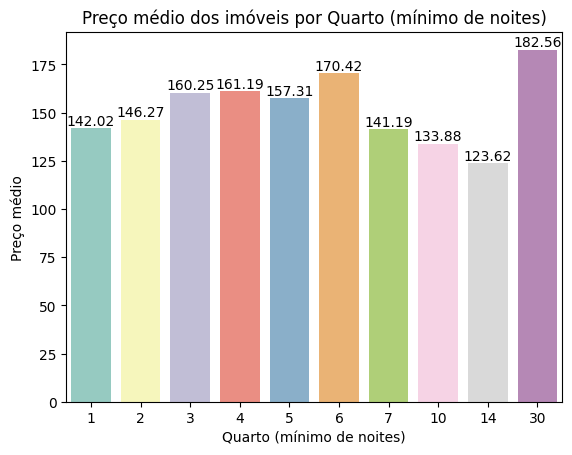

In [772]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Agrupar o dataframe pelas variáveis "minimo_noites" mais frequentes e calcular a média do preço
df_grouped = df[df['minimo_noites'].isin(top_minimo_noites)].groupby('minimo_noites')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Quarto (mínimo de noites)')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Quarto (mínimo de noites)')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* O preço médio dos imóveis aumenta com o aumento do número mínimo de noites requeridas para a estadia. O preço é mais baixo para estadias de 7, 10 e 14 noites, e mais alto para estadias de 30 noites.
* Há uma clara queda no preço médio para estadias quinzenais.
* Descontos para estadias longas: Proprietários podem oferecer descontos para incentivar estadias quinzenais, o que garante renda por um período mais extenso e diminui a rotatividade de hóspedes.
* Custos fixos: Os custos fixos de manutenção do quarto, como limpeza e preparação, são diluídos em estadias quinzenais, o que permite aos proprietários oferecer preços mais baixos.
* Demanda: A demanda por quartos pode ser maior para estadias curtas, o que justifica preços mais altos.

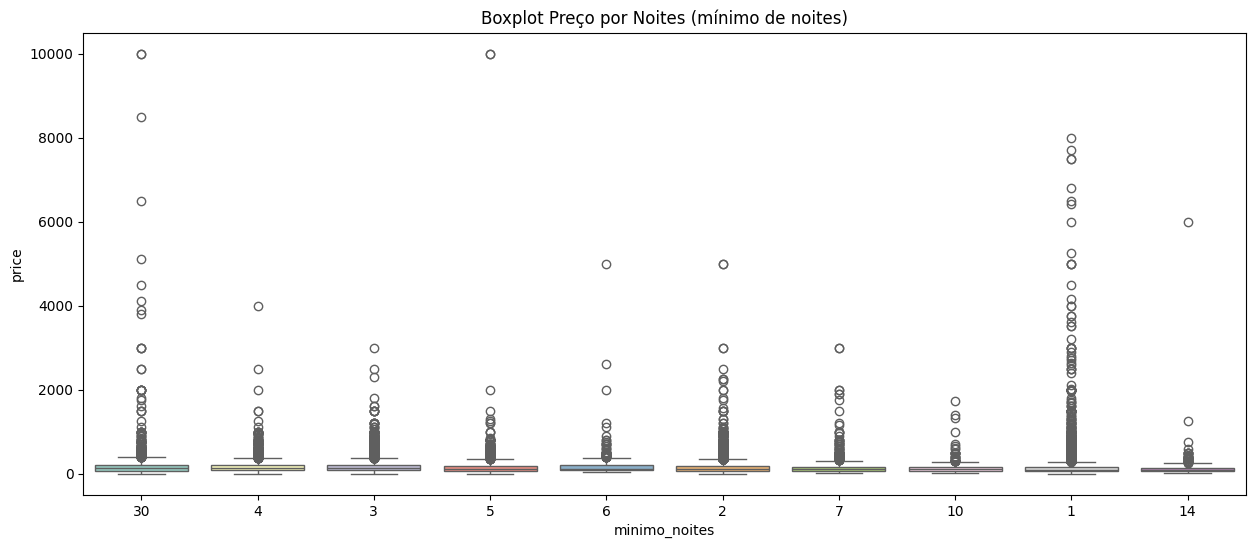

In [773]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Agrupar os dados por bairro e calcular a mediana do preço
noites = df[df['minimo_noites'].isin(top_minimo_noites)].groupby('minimo_noites').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
noites = noites['minimo_noites']

# Criar uma figura com tamanho 15x6
plt.figure(figsize=(15,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='minimo_noites', y='price', data=df[df['minimo_noites'].isin(top_minimo_noites)],
                 order=noites, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço por Noites'
ax.set_title('Boxplot Preço por Noites (mínimo de noites)')

# Mostrar o gráfico
plt.show()

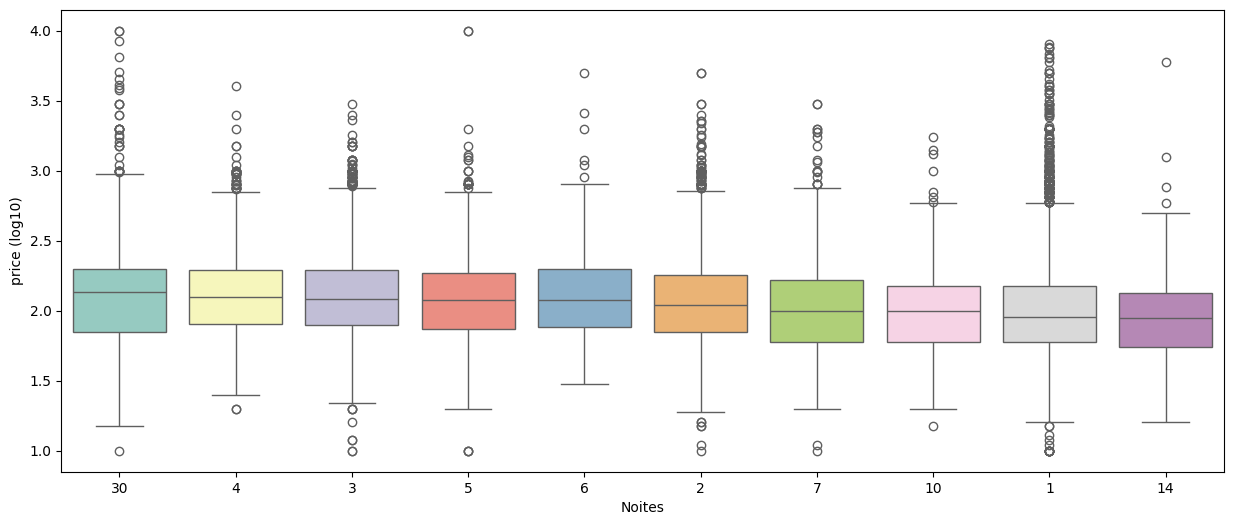

In [774]:
# Contar a frequência de cada variável "minimo_noites"
df_minimo_noites_count = df['minimo_noites'].value_counts()

# Ordenar as variáveis por frequência decrescente
df_minimo_noites_count = df_minimo_noites_count.sort_values(ascending=False)

# Definir o número de variáveis a serem exibidas
numero_variaveis = 10

# Selecionar as "numero_variaveis" variáveis mais frequentes
top_minimo_noites = df_minimo_noites_count.index[:numero_variaveis]

# Agrupar os dados por noites e calcular a mediana do preço
noites = df[df['minimo_noites'].isin(top_minimo_noites)].groupby('minimo_noites').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
noites = noites['minimo_noites']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df[df['minimo_noites'].isin(top_minimo_noites)].copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='minimo_noites', y ='price', data = log, 
                 order = noites, 
                 palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Noites'
ax.set_xlabel('Noites')

# Definir o rótulo do eixo y como 'price (log10)'
ax.set_ylabel('price (log10)')

# Mostrar o gráfico
plt.show()

* Há muitos outliers em cada categoria do número mínimo de noites; esses são pontos que caem bem fora da faixa interquartil. Isso pode indicar que há alguns imóveis muito caros ou muito baratos que não seguem uma tendência.
* No geral, o gráfico mostra que o preço por noite aumenta com o número mínimo de noites. Há uma grande variabilidade nos preços por noite, especialmente para estadia minima de 30 noites. Há também alguns valores discrepantes nos gráficos, que representam preços por noite muito mais altos ou mais baixos do que a maioria dos outros valores.

Conclusões finais:

* Os gráficos mostram que há uma relação entre o número mínimo de noites e o preço por noite dos imóveis. Essa relação pode ser influenciada por fatores como oferta, demanda, custos fixos e descontos.
* Também mostram que há uma grande diversidade de preços por noite para cada categoria do número mínimo de noites. Isso pode refletir as diferentes características, localizações e qualidades dos imóveis disponíveis.
* Os gráficos podem ser úteis para clientes que querem comparar os preços dos imóveis de acordo com o número mínimo de noites que pretendem ficar. O gráfico também pode ser útil para proprietários que querem ajustar os seus preços de acordo com o número mínimo de noites que oferecem.

In [775]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## Número de Reviews

In [776]:
df.numero_de_reviews.nunique()

394

In [777]:
df.numero_de_reviews.value_counts().head()

numero_de_reviews
0    10052
1     5244
2     3465
3     2520
4     1994
Name: count, dtype: int64

Como a variável "classificacao_reviews" tem muitos valores distintos, vamos classificá-los em grupos:

* Classificamos como 1 os valores com 0 review.
* Classificamos como 2 os valores com 1, 2 ou 3 reviews.
* Classificamos como 3 os valores com 4, 5 ou 6 reviews.
* Classificamos como 4 os valores com 7, 8 ou 9 reviews.
* Classificamos como 5 os valores entre 10 e 15 reviews.
* Classificamos como 6 os valores entre 16 e 26 reviews.
* Classificamos como 7 os valores entre 27 e 40 reviews.
* Classificamos como 8 os valores entre 41 e 90 reviews.
* Classificamos como 9 os valores entre 91 e 160 reviews.
* Classificamos como 10 os demais valores.

In [778]:
# Definindo os intervalos e os rótulos das categorias
bins = [-1, 0, 3, 6, 9, 15, 26, 40, 90, 160, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Criando uma nova coluna com a classificação dos valores em 10 categorias
df['classificacao_reviews'] = pd.cut(df['numero_de_reviews'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classificacao_reviews
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,8
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,1
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,10
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,8


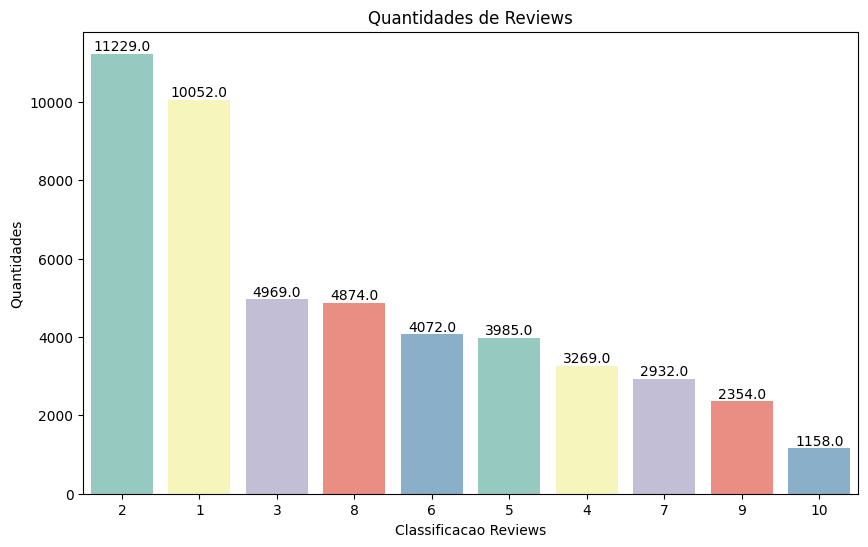

In [779]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_reviews', data=df, order= df['classificacao_reviews'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews'
ax.set_xlabel('Classificacao Reviews')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Quantidades de Reviews')

# Mostrar o gráfico
plt.show()

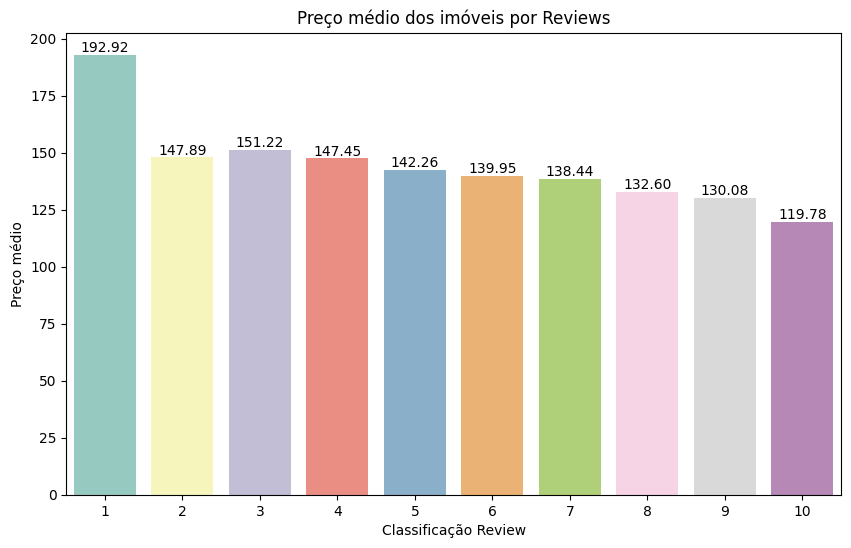

In [780]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('classificacao_reviews')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Classificação Review')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Reviews')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Os imóveis com classificação de review do grupo 1, ou seja, sem review têm o preço médio mais alto, enquanto os imóveis com classificação de review do grupo 10, o grupo com a maior quantidade de reviews têm o preço médio mais baixo.
* O preço médio dos imóveis geralmente diminui à medida que a classificação de review aumenta, com algumas flutuações entre as classificações de 2 a 7.
* Isso pode sugerir que os imóveis com classificações de review mais baixas são mais caros porque são mais raros, mais luxuosos ou mais procurados. Por outro lado, os imóveis com classificações de review mais altas podem ser mais baratos porque são mais comuns, mais simples ou menos demandados.

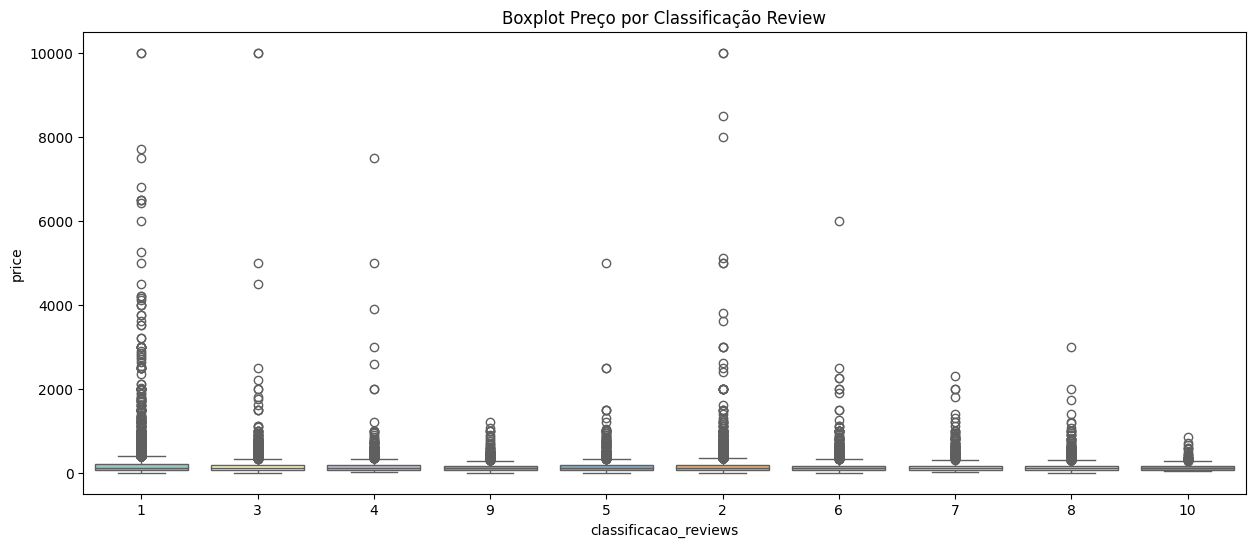

In [781]:
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna da Classificação Review
rev = rev['classificacao_reviews']

# Criar uma figura com tamanho 15x6
plt.figure(figsize=(15,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pela classificação e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews', y='price', data=df, order=rev, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço Classificação Review'
ax.set_title('Boxplot Preço por Classificação Review')

# Mostrar o gráfico
plt.show()

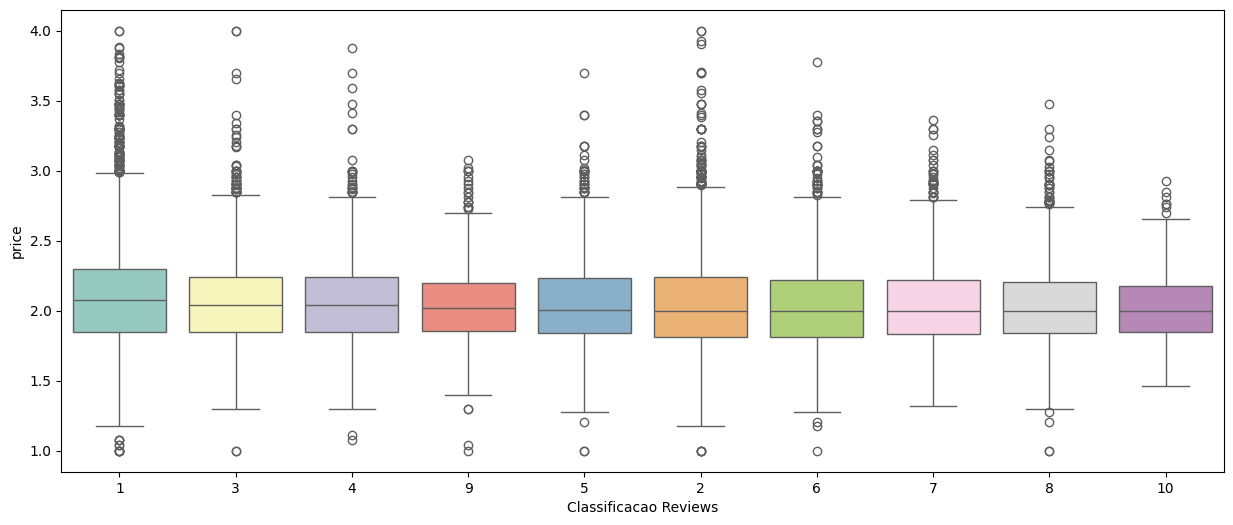

In [782]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
rev = rev['classificacao_reviews']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews'
ax.set_xlabel('Classificacao Reviews')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Os imóveis com classificação de review de 1 têm uma maior variação de preços, com vários outliers indicando alguns imóveis muito mais caros.
* Os imóveis com classificação de review de 9 e 10 têm uma menor variação de preços e menos outliers, sugerindo mais consistência na precificação.
* Os imóveis com outras classificações de review (2, 3, 4, 5, 6, 7, 8) mostram uma variabilidade moderada de preços, mas não tão diversa quanto a classificação de review 1.
* Não há uma tendência clara que mostre que classificações de review mais altas ou mais baixas se correlacionam com preços mais altos ou mais baixos; há variabilidade em todas as classificações.

Conclusões finais:

* Os gráficos mostram que há uma relação inversa entre o preço médio dos imóveis e a classificação de review. Essa relação pode ser influenciada por fatores como oferta, demanda, qualidade e preferência dos usuários.
* Também mostram que há uma grande diversidade de preços dos imóveis para cada classificação de review. Isso pode refletir as diferentes características, localizações e qualidades dos imóveis disponíveis.

## Reviews Por Mês

In [783]:
# Usando fillna para substituir os valores NaN por 0
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

In [784]:
# Verificando valores minimos e máximos de reviews mensais
df.reviews_por_mes.min(), df.reviews_por_mes.max()

(0.0, 58.5)

In [785]:
# Verificando a quantidade de cada Review
df.reviews_por_mes.value_counts().head()

reviews_por_mes
0.00    10052
0.02      919
0.05      893
1.00      893
0.03      804
Name: count, dtype: int64

Como a variável "reviews_por_mes" tem muitos valores distintos, vamos classificá-los em grupos:

* Classificamos como 1 os valores com 0 review.
* Classificamos como 2 os valores entre 0 e 0.25 reviews.
* Classificamos como 3 os valores entre 0.25 e 0.5 reviews.
* Classificamos como 4 os valores entre 0.5 e 1 reviews.
* Classificamos como 5 os valores entre 1 e 1.5 reviews.
* Classificamos como 6 os valores entre 1.5 e 2.5 reviews.
* Classificamos como 7 os valores entre 2.5 e 3.5 reviews.
* Classificamos como 8 os demais valores.

In [786]:
# Definindo os intervalos e os rótulos dos grupos
bins = [-1, 0, 0.25, 0.5, 1, 1.5, 2.5, 3.5, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8]

# Criando uma nova coluna com a classificação dos valores em 9 grupos
df['classificacao_reviews_por_mes'] = pd.cut(df['reviews_por_mes'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classificacao_reviews,classificacao_reviews_por_mes
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,8,3
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,1,1
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,10,8
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4,2
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,8,4


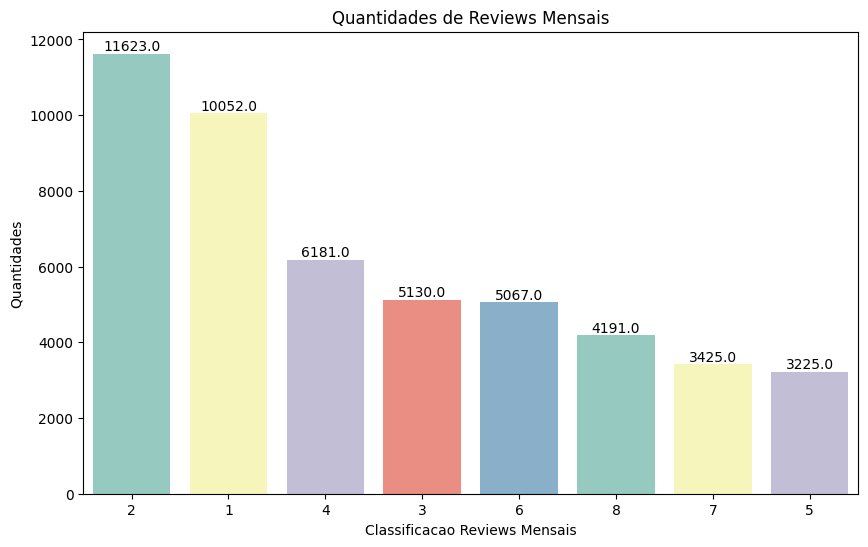

In [787]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_reviews_por_mes', data=df, order= df['classificacao_reviews_por_mes'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensais'
ax.set_xlabel('Classificacao Reviews Mensais')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Quantidades de Reviews Mensais')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* A maioria dos reviews por mês se enquadra na categoria 2 (0 a 0.25 reviews) e na categoria 1 (0 review), com contagens de 11623 e 10052 respectivamente.
* As categorias 4 (0.5 a 1 reviews), 3 (0.25 a 0.5 reviews) e 6 (1.5 a 2.5) têm um número moderado de reviews mensais.
* As categorias com maiores contagens de reviews por mês, como as categorias 8, 7 e 5, têm significativamente menos instâncias.

Isso sugere que a maioria dos imóveis tem pouca ou nenhuma avaliação dos hóspedes, enquanto alguns têm avaliações muito frequentes. Talvez isso esteja relacionado à popularidade, à qualidade ou ao preço dos imóveis. 

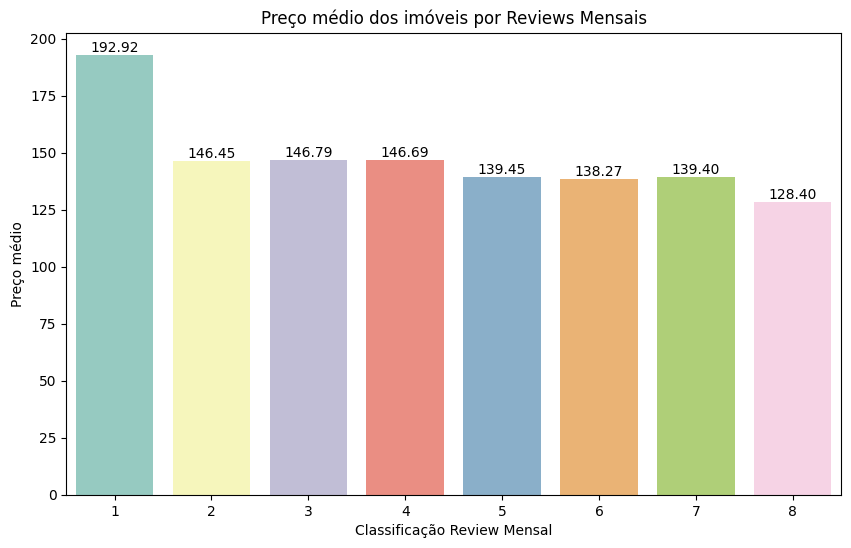

In [788]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('classificacao_reviews_por_mes')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Classificação Review Mensal')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Reviews Mensais')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* O preço médio dos imóveis tende a diminuir à medida que a classificação do review mensal aumenta.
* O preço médio é mais alto para imóveis com uma classificação de review mensal de 1, que são aqueles que não têm nenhum review. Isso pode sugerir que esses imóveis são novos, de luxo ou pouco divulgados, e por isso têm preços mais elevados.
* O preço médio é mais baixo para imóveis com uma classificação de review mensal de 8, que são aqueles que têm mais de 3.5 reviews por mês. Isso pode indicar que esses imóveis são mais simples, populares ou em promoção, e por isso têm preços mais acessíveis.

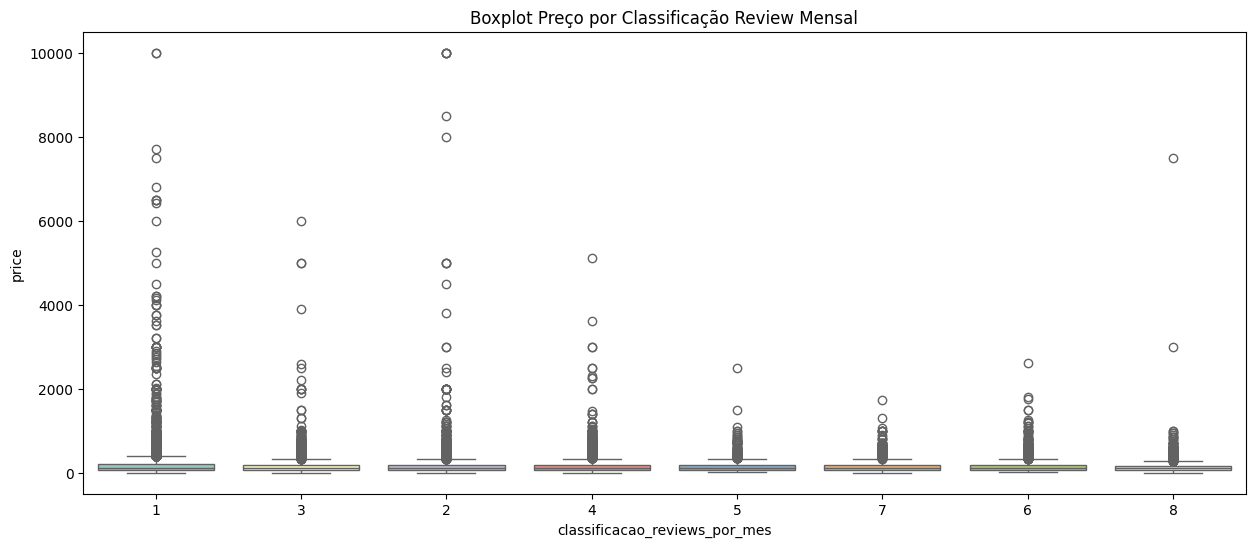

In [789]:
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews_por_mes').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna da Classificação Review por mes
rev = rev['classificacao_reviews_por_mes']

# Criar uma figura com tamanho 15x6
plt.figure(figsize=(15,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pela classificação e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews_por_mes', y='price', data=df, order=rev, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço Classificação Review Mensal'
ax.set_title('Boxplot Preço por Classificação Review Mensal')

# Mostrar o gráfico
plt.show()

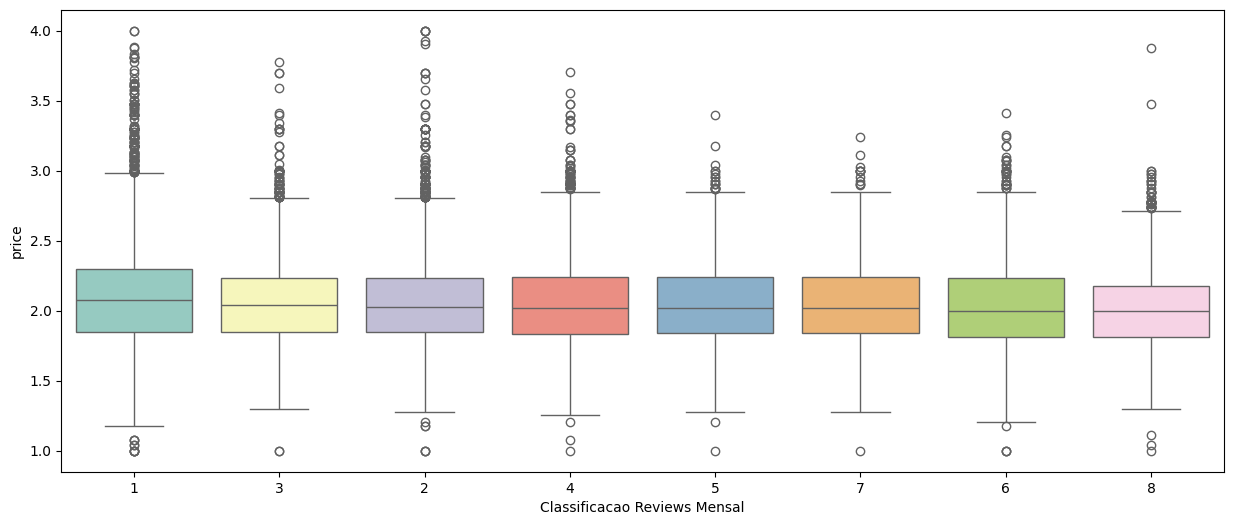

In [790]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_reviews_por_mes').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
rev = rev['classificacao_reviews_por_mes']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_reviews_por_mes', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensal'
ax.set_xlabel('Classificacao Reviews Mensal')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Há uma grande dispersão dos preços em todas as categorias, indicando que existem imóveis com preços muito diferentes dentro da mesma classificação de review mensal.
* Os outliers são mais frequentes e mais extremos nas categorias com menos reviews mensais, como as categorias 1 e 2. Isso pode sugerir que essas categorias contêm imóveis que são muito caros ou muito baratos em relação à média do mercado.
* As categorias com mais reviews mensais, como as categorias 5, 6, 7 e 8, têm uma distribuição mais concentrada dos preços, com menos outliers. Isso pode indicar que esses imóveis têm preços mais próximos da média do mercado e são mais padronizados.

Conclusões finais:

* Existe uma correlação negativa entre os reviews mensais e os preços dos imóveis, ou seja, quanto mais reviews um imóvel recebe, menor tende a ser o seu preço.
* Os imóveis com poucos ou nenhum review mensal podem ter preços mais altos por serem mais exclusivos, diferenciados ou desconhecidos pelos hóspedes.
* Os imóveis com muitos reviews mensais podem ter preços mais baixos por serem mais acessíveis, comuns ou em oferta pelos anfitriões.
* Há uma grande variação de preços dentro de cada categoria de review mensal, o que indica que outros fatores também influenciam o valor dos imóveis, como a localização, o tamanho, o tipo, os serviços, etc.

## Quantidade de Hosts

In [791]:
# Verificando os valores minimos e máximos de listagens
df.calculado_host_listings_count.min(), df.calculado_host_listings_count.max()

(1, 327)

In [792]:
# Verificando quantos hosts fizeram determinadas quantidades de listagens
df.calculado_host_listings_count.value_counts().head()

calculado_host_listings_count
1    32303
2     6658
3     2853
4     1440
5      845
Name: count, dtype: int64

Como a variável "calculado_host_listings_count" tem muitos valores distintos, vamos classificá-los em grupos:

* Classificamos como 1 os valores com 1 listagem por host.
* Classificamos como 2 os valores com 2 e 3 listagens por host.
* Classificamos como 3 os valores de 4 e 10 Listagens por host.
* Classificamos como 4 os demais valores.

In [793]:
# Definindo os intervalos e os rótulos dos grupos
bins = [0, 1, 3, 10, np.inf]
labels = [1, 2, 3, 4]

# Criando uma nova coluna com a classificação dos valores em 9 grupos
df['classificacao_hosts'] = pd.cut(df['calculado_host_listings_count'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classificacao_reviews,classificacao_reviews_por_mes,classificacao_hosts
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,8,3,2
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,1,1,1
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,10,8,1
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4,2,1
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,8,4,1


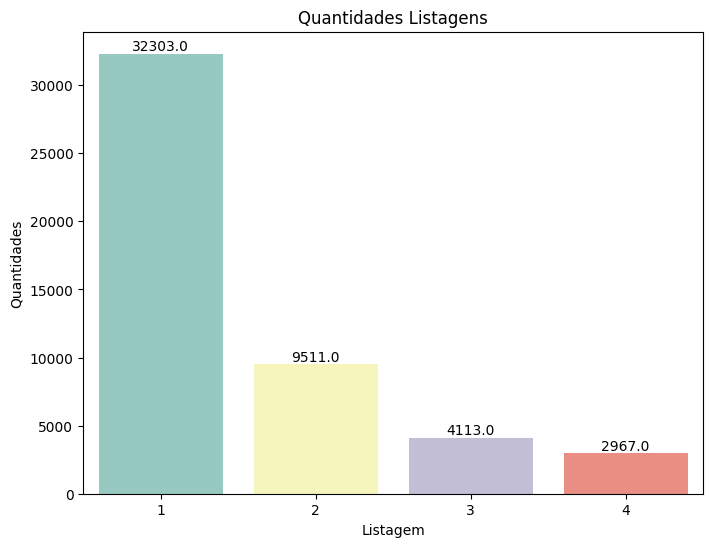

In [794]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_hosts', data=df, order= df['classificacao_hosts'].value_counts().index, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Host'
ax.set_xlabel('Listagem')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Quantidades Listagens')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Uma grande maioria dos hosts tem apenas uma listagem, como indicado pela barra verde. Este grupo constitui o maior segmento de longe.
* O número de hosts diminui à medida que o número de listagens por host aumenta. Essa tendência é visível pela redução drástica na quantidade da barra um para as barras dois a quatro.
* Hosts com mais de dez listagens são o menor grupo.

Em suma: Os dados visualizados neste gráfico indicam que a maioria dos hosts tem apenas uma listagem. À medida que avançamos para números mais altos de listagens por host, sua frequência diminui significativamente.

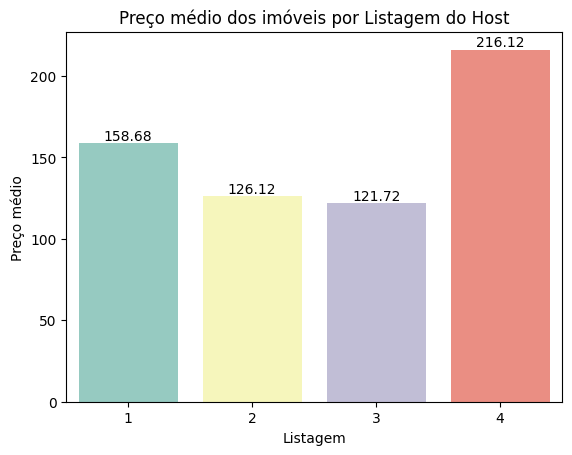

In [795]:
# Agrupar o dataframe por classificacao_hosts e calcular a média do preço
df_grouped = df.groupby('classificacao_hosts')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Listagem')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Listagem do Host')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Os anfitriões com apenas uma listagem têm um preço médio de propriedade moderadamente alto, de 158.68 dolares.
* Aqueles com duas ou três listagens têm preços médios mais baixos, em torno de 120 dolares, indicando que os anfitriões com menos listagens tendem a oferecer suas propriedades a preços mais competitivos.
* Curiosamente, os anfitriões que têm entre quatro e dez listagens também se enquadram nessa faixa de preços mais baixos, sugerindo que não há um aumento significativo nos preços das propriedades dentro dessa faixa de contagem de listagens.
* No entanto, os anfitriões com mais de dez listagens aumentam significativamente seus preços de propriedade, como evidenciado pelo aumento acentuado para um preço médio de mais de 216 dolares.

Concluindo, o gráfico mostra que há uma relação inversa entre o número de listagens por anfitrião e o preço médio das propriedades, exceto para os anfitriões com muitas listagens, que cobram preços muito mais altos do que os demais. Isso pode indicar que esses anfitriões têm propriedades de luxo ou de alta demanda, ou que eles estão explorando o mercado de aluguel de curto prazo. 

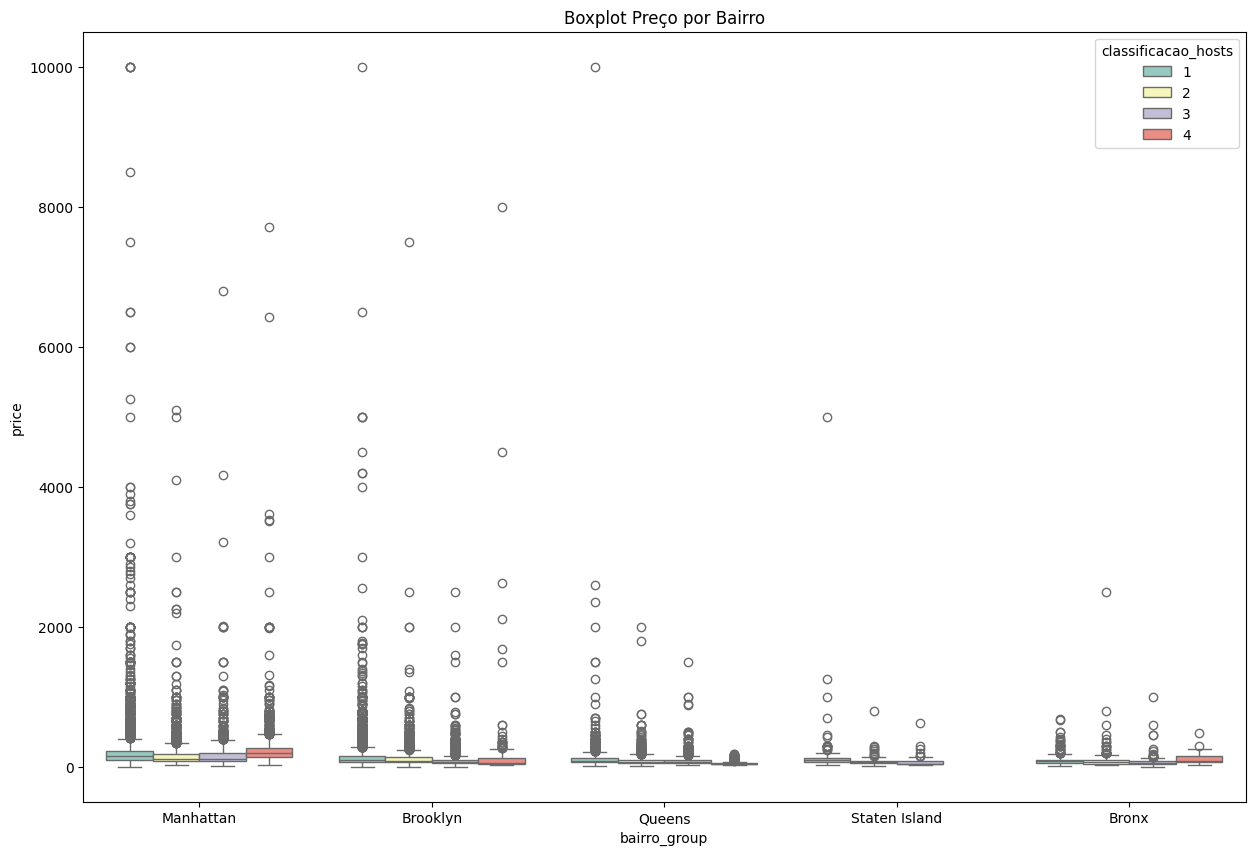

In [796]:
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 15x10
plt.figure(figsize=(15,10))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y='price', data=df, hue = 'classificacao_hosts',
                 order=bairros, palette=sns.color_palette("Set3", 4))

# Definir o título do gráfico como 'Boxplot Preço por Bairro'
ax.set_title('Boxplot Preço por Bairro')

# Mostrar o gráfico
plt.show()

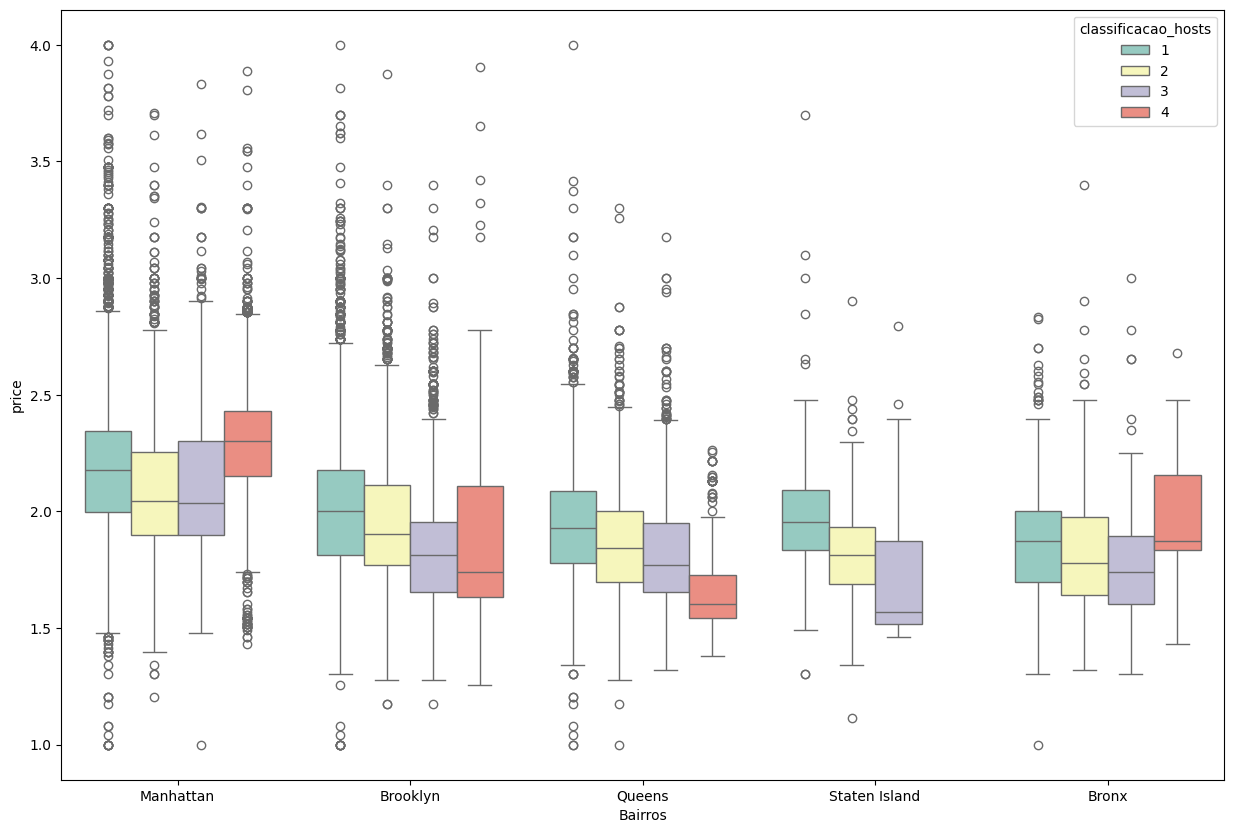

In [797]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 15x10
plt.figure(figsize = (15,10))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, 
                 hue = 'classificacao_hosts',order = bairros, 
                 palette = sns.color_palette("Set3", 4))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Há uma tendência notável de que os anfitriões com mais listagens (classificação 4) tendem a ter uma faixa maior de preços, incluindo outliers de preços mais altos, especialmente evidentes em Manhattan e Brooklyn. Isso pode indicar que esses anfitriões oferecem acomodações premium ou especializadas, levando a estruturas de preços variadas.
* Os anfitriões com menos listagens (classificações 1, 2 e 3) têm preços medianos semelhantes em todos os bairros, exceto em Manhattan, onde os preços são mais altos. Isso pode indicar que esses anfitriões competem entre si em um mercado mais saturado e homogêneo.
* Staten Island e Bronx têm poucos dados visíveis, o que pode sugerir que esses bairros são menos populares ou acessíveis para os viajantes. Os preços nesses bairros são consistentes em todas as classificações, indicando pouca variação na qualidade ou demanda das propriedades.

Em conclusão, o gráfico mostra que há uma relação entre o número de listagens por anfitrião, o preço das propriedades e o bairro onde estão localizadas. Os anfitriões com muitas listagens tendem a cobrar preços mais altos e variados, especialmente em bairros mais caros e desejados, enquanto os anfitriões com menos listagens tendem a cobrar preços mais baixos e consistentes, independentemente do bairro.

## Disponibilidade

In [799]:
# Verificando os valores minimos e máximos de disponibilidade
df.disponibilidade_365.min(), df.disponibilidade_365.max()

(0, 365)

In [800]:
# Verificando quantos hosts fizeram determinadas quantidades de disponibilidade
df.disponibilidade_365.value_counts().head()

disponibilidade_365
0      17533
365     1294
364      491
1        408
89       361
Name: count, dtype: int64

Como a variável "disponibilidade_365" tem muitos valores distintos, vamos classificá-los em 12 meses:

* Classificamos como 1 mês os valores de 0 a 30.
* Classificamos como 2 meses os valores de 31 a 60.
* Classificamos como 3 meses os valores de 61 a 90.
* Classificamos como 4 meses os valores de 91 a 120.
* Classificamos como 5 meses os valores de 121 a 150.
* Classificamos como 6 meses os valores de 151 a 180.
* Classificamos como 7 meses os valores de 181 a 210.
* Classificamos como 8 meses os valores de 211 a 240.
* Classificamos como 9 meses os valores de 241 a 270.
* Classificamos como 10 meses os valores de 271 a 300.
* Classificamos como 11 meses os valores de 301 a 330.
* Classificamos como 12 meses os valores de 331 a 365.

In [801]:
# Definindo os intervalos e os rótulos dos grupos
bins = [-1, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Criando uma nova coluna com a classificação dos valores em 12 grupos
df['classificacao_disponibilidade'] = pd.cut(df['disponibilidade_365'], bins=bins, labels=labels)

# Mostrando o resultado
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,classificacao_reviews,classificacao_reviews_por_mes,classificacao_hosts,classificacao_disponibilidade
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,8,3,2,12
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,1,1,1,12
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,10,8,1,7
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4,2,1,1
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,8,4,1,5


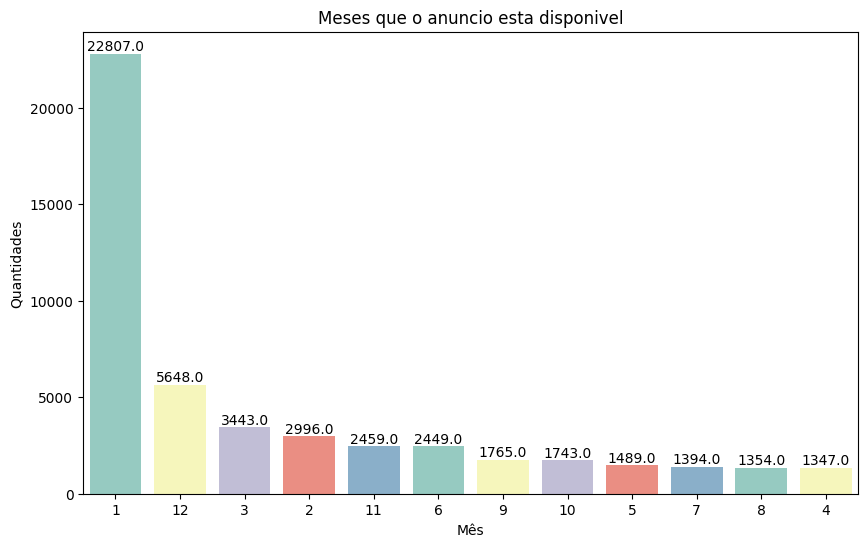

In [805]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='classificacao_disponibilidade', data=df, order= df['classificacao_disponibilidade'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensais'
ax.set_xlabel('Mês')

# Definir o rótulo do eixo y como 'Quantidades'
ax.set_ylabel('Quantidades')

# Definir o título do gráfico como 'Quantidades de Reviews'
ax.set_title('Meses que o anuncio esta disponivel')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* A maioria dos anúncios está disponível apenas por um mês, com 22.807 anúncios nessa categoria.
* Há uma redução drástica na disponibilidade à medida que o número de meses aumenta, indicando que os anfitriões preferem alugar seus espaços por períodos curtos.
* Anúncios disponíveis por períodos prolongados, como doze meses ou mais, são relativamente raros, com apenas 5.648 anúncios nessa categoria.

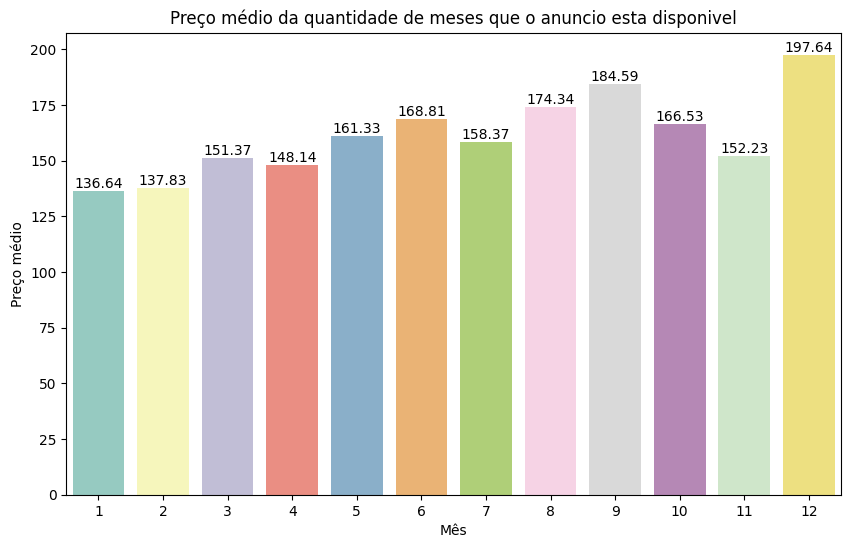

In [807]:
# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Agrupar o dataframe por review e calcular a média do preço
df_grouped = df.groupby('classificacao_disponibilidade')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Mês')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio da quantidade de meses que o anuncio esta disponivel')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* O preço médio aumenta com o aumento do número de meses que o anúncio está disponível, com exceção do 10º mês.
* O menor preço médio é observado no primeiro mês (136,64) e o maior no 12º mês (197,64).
* Há uma variação notável nos preços médios. Eles não seguem um padrão linear ou constante evidente. Porém quanto maior a disponibilidade dos meses, pode-se notar um leve aumento nos preços.

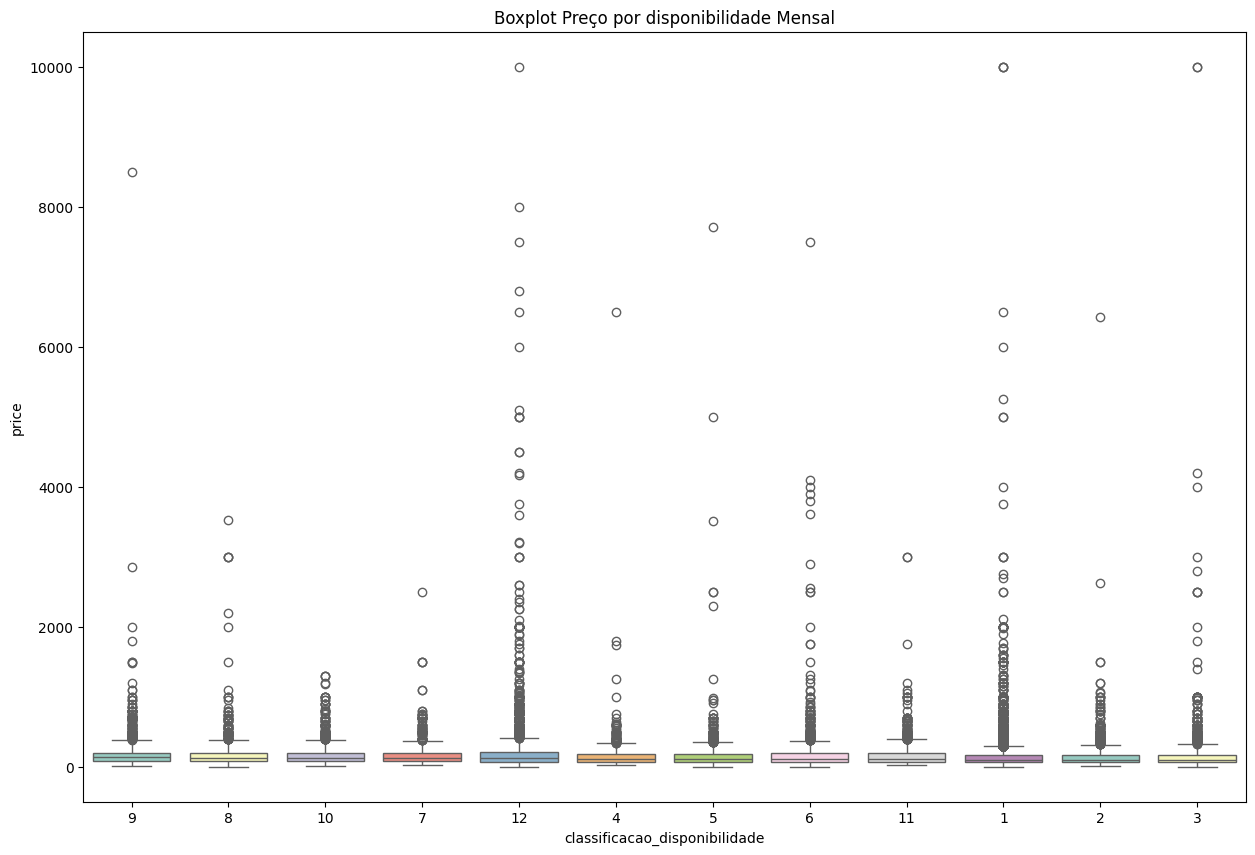

In [809]:
# Agrupar os dados por bairro e calcular a mediana do preço
mes = df.groupby('classificacao_disponibilidade').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna da Classificação Review por mes
mes = mes['classificacao_disponibilidade']

# Criar uma figura com tamanho 15x10
plt.figure(figsize=(15,10))

# Criar um boxplot usando seaborn com os dados originais, ordenando pela classificação e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_disponibilidade', y='price', data=df, order=mes, palette=sns.color_palette("Set3", 10))

# Definir o título do gráfico como 'Boxplot Preço Classificação Review Mensal'
ax.set_title('Boxplot Preço por disponibilidade Mensal')

# Mostrar o gráfico
plt.show()

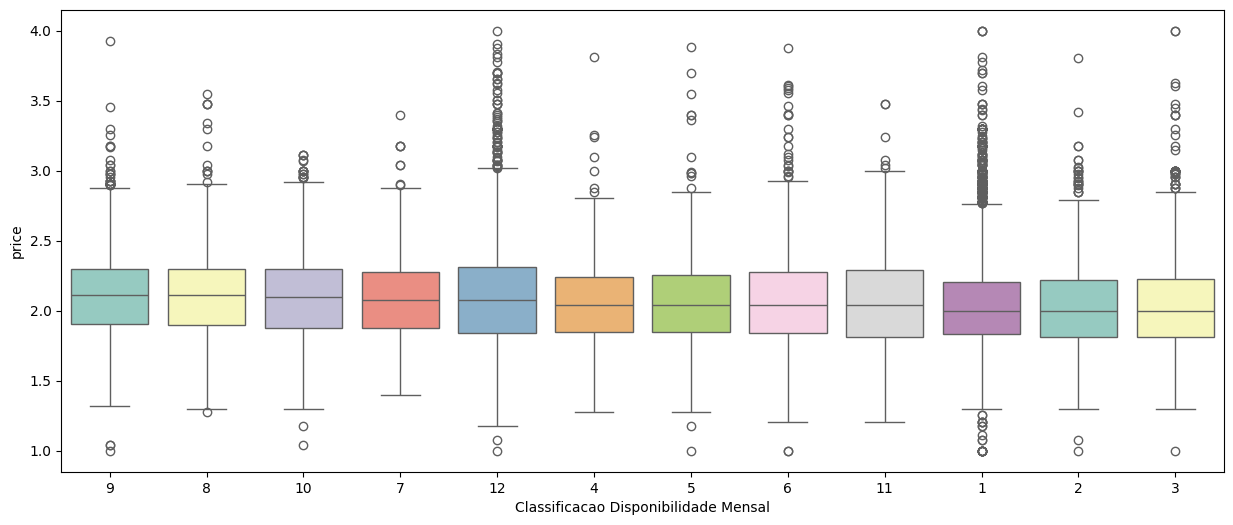

In [810]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
rev = df.groupby('classificacao_disponibilidade').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
rev = rev['classificacao_disponibilidade']

# Criar uma figura com tamanho 15x6
plt.figure(figsize = (15,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='classificacao_disponibilidade', y ='price', data = log, order = rev, palette = sns.color_palette("Set3", 10))

# Definir o rótulo do eixo x como 'Classificacao Reviews Mensal'
ax.set_xlabel('Classificacao Disponibilidade Mensal')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* Há uma grande variação nos preços dentro de cada categoria de disponibilidade mensal, como indicado pela altura das caixas e pela presença de outliers.
* Outliers são comuns, indicando que há ocasionalmente preços muito mais altos do que a mediana em cada categoria.
* O preço mediano parece relativamente consistente entre as diferentes categorias de disponibilidade mensal, como indicado pela linha horizontal dentro de cada caixa.